In [1]:
import warnings
warnings.filterwarnings('ignore')

### API

### Libraries

In [3]:
from typing import List, Annotated, Literal
from typing_extensions import TypedDict

from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

### Func. To gather information for creating prompts

In [5]:
class PromptInstruction(BaseModel):
    """Instruction on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]
    
def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages

def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you ar not able to discern this info, ask them to clarify! Do not attempt to wildly quess.

After you are able to discern all the information, call the relevant tool."""

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_with_tool = llm.bind_tools([PromptInstruction])

### Func. Writing prompt

In [15]:
# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""

def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]['args']
            print(tool_call)
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

### Edges

In [16]:
def get_state(state) -> Literal["prompt", "info", "__end__"]:
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "prompt"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

### Build graph

In [17]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()
workflow = StateGraph(State)

# Add nodes
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)

# Add edges
workflow.add_conditional_edges("info", get_state)
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# Compile graph
graph = workflow.compile(checkpointer=memory)

### Visualize graph

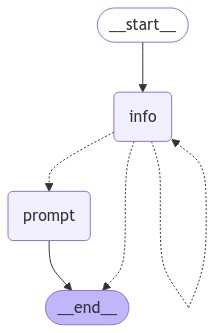

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Run graph

In [19]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    user = input("User (q/Q to quit): ")
    if user in ['q', 'Q']:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit):  영어 회화 초보자의 실력향상을 위해 적절한 가이드라인을 줄 수 있는 프롬프트를 작성해줘.


================================== Ai Message ==================================

프롬프트 템플릿을 작성하기 위해 몇 가지 정보를 더 필요로 합니다.

1. **프롬프트의 목표**: 어떤 특정한 목표를 가지고 있나요? 예를 들어, 회화 연습, 문법 개선, 어휘 확장 등.
2. **프롬프트에 전달될 변수**: 어떤 변수를 프롬프트에 포함시키고 싶으신가요? 예를 들어, 학습자의 현재 수준, 관심 있는 주제 등.
3. **출력에서 하지 말아야 할 제약 조건**: 출력에서 어떤 내용을 포함하지 않기를 원하시나요? 예를 들어, 너무 복잡한 문장 사용 금지 등.
4. **출력에서 반드시 지켜야 할 요구 사항**: 출력이 반드시 따라야 할 규칙이나 요구 사항이 있나요? 예를 들어, 간단한 언어 사용, 단계별 가이드 제공 등.

이 정보를 제공해 주시면, 적절한 프롬프트 템플릿을 작성할 수 있습니다!


User (q/Q to quit):  1. 목표 : 일정 수준의 회화 능력 달성 2. 학습자의 현재 수준, 목표 기간, 목표로 하는 수준 3. 너무 복잡하고 잘 사용되지 않는 단어, 문장 사용 금지 4. 간단한 예시를 들어서 설명, 실제로 원어민이 자주 사용하는 표현 위주의 문장 제시 등


================================== Ai Message ==================================
Tool Calls:
  PromptInstruction (call_bNGxJY4GMpSbTL6EC30KrVm8)
 Call ID: call_bNGxJY4GMpSbTL6EC30KrVm8
  Args:
    objective: 일정 수준의 회화 능력 달성
    variables: ['학습자의 현재 수준', '목표 기간', '목표로 하는 수준']
    constraints: ['너무 복잡하고 잘 사용되지 않는 단어, 문장 사용 금지']
    requirements: ['간단한 예시를 들어서 설명', '실제로 원어민이 자주 사용하는 표현 위주의 문장 제시']
{'objective': '일정 수준의 회화 능력 달성', 'variables': ['학습자의 현재 수준', '목표 기간', '목표로 하는 수준'], 'constraints': ['너무 복잡하고 잘 사용되지 않는 단어, 문장 사용 금지'], 'requirements': ['간단한 예시를 들어서 설명', '실제로 원어민이 자주 사용하는 표현 위주의 문장 제시']}
================================== Ai Message ==================================

**Prompt Template:**

---

**Objective:** Achieve a certain level of conversational ability.

**Instructions:**

1. **Current Level Assessment:** Please provide a brief description of the learner's current language proficiency level (e.g., beginner, intermediate, advanced).

2. **Goal Duration:** Specify the time f

User (q/Q to quit):  q


AI: Byebye
